In [5]:
# Importar bibliotecas e instalar

# Importar as bibliotecas necessárias para o projeto

# Bibliotecas para manipulação e visualização de dados
import pandas as pd  # Manipulação de dados
import seaborn as sns  # Visualização de dados com gráficos
import networkx as nx  # Construção e visualização de grafos
import matplotlib.pyplot as plt  # Gráficos
import numpy as np  # Operações numéricas

# Biblioteca para dividir dados em treinamento e teste
from sklearn.model_selection import train_test_split

# Biblioteca para avaliar o desempenho dos modelos
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, log_loss, roc_auc_score

# Bibliotecas para criação e inferência em redes bayesianas
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import KBinsDiscretizer  # Discretização de variáveis contínuas

# Instalação do nbconvert para exportar notebooks (opcional para VSCode)
# !pip install nbconvert  # Descomentar para instalar se necessário


RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace prims; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /dev/null:488; latest registration was registered at /dev/null:488

In [ ]:


# Carregando o dataset do arquivo CSV fornecido pelo usuário
file_path = 'C:\\programação\\projeto de IA\\titanic\\train.csv'
try:
    dataset = pd.read_csv(file_path)
    dataset.head()
except Exception as e:
    e



In [ ]:
# 1.1 Limpar o DataSet

# Exibir as primeiras linhas do dataset para uma visão inicial
print("Primeiras linhas do dataset:")
print(data.head())

# Verificar valores ausentes em cada coluna
print("\nValores ausentes por coluna:")
print(data.isnull().sum())

# Preencher valores ausentes na coluna 'Age' com a mediana da idade
data['Age'].fillna(data['Age'].median(), inplace=True)

# Preencher valores ausentes na coluna 'Embarked' com o valor mais frequente
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Excluir a coluna 'Cabin' devido ao grande número de valores ausentes
data.drop(columns=['Cabin'], inplace=True)

# Converter a coluna 'Sex' de categórica para numérica (0 = male, 1 = female)
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Converter a coluna 'Embarked' de categórica para numérica (S = 0, C = 1, Q = 2)
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Selecionar as colunas relevantes para o modelo
data = data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]


Primeiras linhas do dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450

In [ ]:
# Estruturação da Rede Bayesiana

# Discretizar as colunas 'Age' e 'Fare' para uso na rede bayesiana

# Configurar o discretizador para dividir a idade em 5 faixas de frequência semelhante (quantile)
age_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
data['Age'] = age_discretizer.fit_transform(data[['Age']]).astype(int)

# Discretizar 'Fare' em 4 faixas (quartis)
data['Fare'] = pd.qcut(data['Fare'], 4, labels=[0, 1, 2, 3]).astype(int)

# Converter todas as colunas para tipo inteiro (necessário para modelos bayesianos)
data = data.astype(int)

# Verificar os dados após a discretização
print("\nDados após a discretização de 'Age' com KBinsDiscretizer:")
print(data.head())

# Verificar os dados após o pré-processamento
print("\nDados após o pré-processamento:")
print(data.head())



Dados após a discretização de 'Age' com KBinsDiscretizer:
   Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
0         0       3    0    1      1      0     0         0
1         1       1    1    3      1      0     3         1
2         1       3    1    1      0      0     1         0
3         1       1    1    2      1      0     3         0
4         0       3    0    2      0      0     1         0

Dados após o pré-processamento:
   Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
0         0       3    0    1      1      0     0         0
1         1       1    1    3      1      0     3         1
2         1       3    1    1      0      0     1         0
3         1       1    1    2      1      0     3         0
4         0       3    0    2      0      0     1         0


c:\Users\crish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [ ]:
# Seleção de Variáveis com Mutual Information

from sklearn.feature_selection import mutual_info_classif

# Definir as variáveis independentes (X) e a variável alvo (y)
X = data.drop('Survived', axis=1)
y = data['Survived']

# Calcular a mutual information
mi = mutual_info_classif(X, y, discrete_features=True)

# Exibir a importância das variáveis
importance = pd.Series(mi, index=X.columns)
importance.sort_values(ascending=False, inplace=True)
print("Importância das variáveis (Mutual Information):")
print(importance)


Importância das variáveis (Mutual Information):
Sex         0.150870
Pclass      0.058107
Fare        0.046180
SibSp       0.023197
Parch       0.016366
Embarked    0.014233
Age         0.004641
dtype: float64


In [ ]:
# Seleção das 7 Variáveis Mais Importantes

# Supondo que a série de Informação Mútua esteja armazenada na variável 'importance'
top_7_features = importance.head(7)  # Seleciona as 7 primeiras variáveis com maior Informação Mútua
print("Top 7 variáveis mais importantes com base na Informação Mútua:")
print(top_7_features)

# Criar uma nova tabela com as 7 variáveis mais importantes + a coluna alvo 'Survived'
top_7_vars = top_7_features.index.tolist()  # Obtém os nomes das 7 variáveis
new_df = data[top_7_vars + ['Survived']]  # Cria a nova tabela com as variáveis selecionadas e a coluna alvo

# Exibir as primeiras linhas da nova tabela para verificação
print("\nNova tabela com as 7 variáveis mais importantes e a coluna alvo:")
print(new_df.head(50))

# Salvar a nova tabela em um arquivo CSV para uso futuro ou compartilhamento
new_df.to_csv('top_7_features_table.csv', index=False)
print("Nova tabela salva como 'top_7_features_table.csv'")



Top 7 variáveis mais importantes com base na Informação Mútua:
Sex         0.150870
Pclass      0.058107
Fare        0.046180
SibSp       0.023197
Parch       0.016366
Embarked    0.014233
Age         0.004641
dtype: float64

Nova tabela com as 7 variáveis mais importantes e a coluna alvo:
    Sex  Pclass  Fare  SibSp  Parch  Embarked  Age  Survived
0     0       3     0      1      0         0    1         0
1     1       1     3      1      0         1    3         1
2     1       3     1      0      0         0    1         1
3     1       1     3      1      0         0    2         1
4     0       3     1      0      0         0    2         0
5     0       3     1      0      0         2    2         0
6     0       1     3      0      0         0    3         0
7     0       3     2      3      1         0    0         0
8     1       3     1      0      2         0    1         1
9     1       2     2      1      0         1    0         1
10    1       3     2      1      1   

In [ ]:
# Treinamento e Ajuste de Hiperparâmetros

# Nesta seção, exploraremos como ajustar diferentes hiperparâmetros para melhorar o desempenho dos modelos de rede bayesiana.
# Ajustaremos parâmetros como o tipo de prior e o tamanho de amostra equivalente no BayesianEstimator.



# Carregar o arquivo CSV que contém as colunas mais importantes para análise
new_df = pd.read_csv('top_7_features_table.csv')
print(f"Número de linhas no dataset carregado: {len(new_df)}")  # Deve exibir o número correto de registros

# Opcional: Verificar as primeiras linhas do novo DataFrame
print(new_df.head())


from sklearn.model_selection import train_test_split

# Definir a variável alvo e as variáveis preditoras
X = new_df.drop('Survived', axis=1)
y = new_df['Survived']

# Dividir os dados em conjuntos de treinamento e teste
train_data, test_data = train_test_split(new_df, test_size=0.2, random_state=42, stratify=new_df['Survived'])

print(f"\nConjunto de Treinamento: {len(train_data)} registros")
print(f"Conjunto de Teste: {len(test_data)} registros")





# Definir diferentes configurações para o BayesianEstimator
estimator_configs = [
    {'prior_type': 'BDeu', 'equivalent_sample_size': 1},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 10},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 20},
    # Adicione mais configurações conforme necessário
]

# Lista para armazenar os melhores modelos com diferentes configurações
best_models = []

# Iterar sobre as configurações do estimador
for est_config in estimator_configs:
    # Estimar a estrutura usando o BIC Score
    est_hc = HillClimbSearch(train_data)
    best_model_bic = est_hc.estimate(scoring_method=BicScore(train_data))
    
    # Criar o modelo de rede bayesiana com as arestas encontradas
    model_bic = BayesianNetwork(best_model_bic.edges())
    
    # Ajustar o modelo com o BayesianEstimator usando a configuração atual
    model_bic.fit(train_data, estimator=BayesianEstimator, prior_type=est_config['prior_type'], equivalent_sample_size=est_config['equivalent_sample_size'])
    
    # Adicionar o modelo treinado e sua configuração à lista
    best_models.append({
        'model': model_bic,
        'estimator_config': est_config
    })
    
    # Opcional: Exibir a configuração atual
    print(f"Modelo BIC treinado com configuração: {est_config}")


Número de linhas no dataset carregado: 891
   Sex  Pclass  Fare  SibSp  Parch  Embarked  Age  Survived
0    0       3     0      1      0         0    1         0
1    1       1     3      1      0         1    3         1
2    1       3     1      0      0         0    1         1
3    1       1     3      1      0         0    2         1
4    0       3     1      0      0         0    2         0

Conjunto de Treinamento: 712 registros
Conjunto de Teste: 179 registros


  0%|          | 7/1000000 [00:00<32:43:08,  8.49it/s] 


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 1}


  0%|          | 7/1000000 [00:00<27:34:24, 10.07it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 10}


  0%|          | 7/1000000 [00:00<25:56:30, 10.71it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 20}


In [ ]:
# Treinamento BIC

# Separar a variável alvo ('Survived') das variáveis preditoras
X = data.drop('Survived', axis=1)
y = data['Survived']

# Dividir os dados em conjuntos de treinamento e teste
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Survived'])

print(f"\nConjunto de Treinamento: {len(train_data)} registros")
print(f"Conjunto de Teste: {len(test_data)} registros")


# Treinar o modelo usando Hill Climbing com o BIC Score
est_hc = HillClimbSearch(train_data)
best_model_bic = est_hc.estimate(scoring_method=BicScore(train_data))

# Criar e treinar o modelo de rede bayesiana com a estrutura BIC encontrada
model_bic = BayesianNetwork(best_model_bic.edges())
model_bic.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)  # Ajuste conforme necessário



Conjunto de Treinamento: 712 registros
Conjunto de Teste: 179 registros


  0%|          | 7/1000000 [00:00<26:02:44, 10.66it/s] 


In [ ]:
# Treinamento BIC com Diferentes Hiperparâmetros

# Definir diferentes configurações específicas para o BIC Score
bic_estimator_configs = [
    {'prior_type': 'BDeu', 'equivalent_sample_size': 1},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 10},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 20},
    # Adicione mais configurações conforme necessário
]

# Lista para armazenar os modelos BIC treinados com diferentes hiperparâmetros
bic_models = []

# Iterar sobre as configurações do estimador para BIC
for est_config in bic_estimator_configs:
    # Estimar a estrutura usando o BIC Score
    est_hc_bic = HillClimbSearch(train_data)
    best_model_bic = est_hc_bic.estimate(scoring_method=BicScore(train_data))
    
    # Criar o modelo de rede bayesiana com as arestas encontradas
    model_bic = BayesianNetwork(best_model_bic.edges())
    
    # Ajustar o modelo com o BayesianEstimator usando a configuração atual
    model_bic.fit(train_data, estimator=BayesianEstimator, prior_type=est_config['prior_type'], equivalent_sample_size=est_config['equivalent_sample_size'])
    
    # Adicionar o modelo treinado e sua configuração à lista
    bic_models.append({
        'model': model_bic,
        'estimator_config': est_config
    })
    
    # Opcional: Exibir a configuração atual
    print(f"Modelo BIC treinado com configuração: {est_config}")


  0%|          | 7/1000000 [00:00<23:48:34, 11.67it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 1}


  0%|          | 7/1000000 [00:00<23:34:13, 11.78it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 10}


  0%|          | 7/1000000 [00:00<23:27:57, 11.84it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 20}


In [ ]:
# Treinamento K2

# Treinar o modelo usando Hill Climbing com o K2 Score
k2score = K2Score(train_data)
best_model_k2 = HillClimbSearch(train_data).estimate(scoring_method=k2score)

# Criar e treinar o modelo de rede bayesiana com a estrutura K2 encontrada
model_k2 = BayesianNetwork(best_model_k2.edges())
model_k2.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)  # Ajuste conforme necessário


  0%|          | 27/1000000 [00:01<12:54:40, 21.51it/s]


In [ ]:
# Treinamento K2 com Diferentes Hiperparâmetros

# Definir diferentes configurações específicas para o K2 Score
k2_estimator_configs = [
    {'prior_type': 'BDeu', 'equivalent_sample_size': 1},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 10},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 20},
    # Adicione mais configurações conforme necessário
]

# Lista para armazenar os modelos K2 treinados com diferentes hiperparâmetros
k2_models = []

# Iterar sobre as configurações do estimador para K2
for est_config in k2_estimator_configs:
    # Estimar a estrutura usando o K2 Score
    est_hc_k2 = HillClimbSearch(train_data)
    best_model_k2 = est_hc_k2.estimate(scoring_method=K2Score(train_data))
    
    # Criar o modelo de rede bayesiana com as arestas encontradas
    model_k2 = BayesianNetwork(best_model_k2.edges())
    
    # Ajustar o modelo com o BayesianEstimator usando a configuração atual
    model_k2.fit(train_data, estimator=BayesianEstimator, prior_type=est_config['prior_type'], equivalent_sample_size=est_config['equivalent_sample_size'])
    
    # Adicionar o modelo treinado e sua configuração à lista
    k2_models.append({
        'model': model_k2,
        'estimator_config': est_config
    })
    
    # Opcional: Exibir a configuração atual
    print(f"Modelo K2 treinado com configuração: {est_config}")


  0%|          | 27/1000000 [00:01<13:46:37, 20.16it/s]


Modelo K2 treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 1}


  0%|          | 27/1000000 [00:01<12:27:27, 22.30it/s]


Modelo K2 treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 10}


  0%|          | 27/1000000 [00:01<14:27:37, 19.21it/s]


Modelo K2 treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 20}


In [ ]:
# Avaliação do Modelo

# Função para realizar predições usando inferência nas redes bayesianas
def predict(model, data, evidence_vars, target_var='Survived'):
    inference = VariableElimination(model)
    predictions = []
    for idx, row in data.iterrows():
        evidence = {var: row[var] for var in evidence_vars}
        try:
            query_result = inference.query(variables=[target_var], evidence=evidence)
            prob = query_result.values
            predicted_state = np.argmax(prob)
            predictions.append(int(predicted_state))
        except Exception as e:
            predictions.append(0)  # Valor padrão em caso de erro
    return predictions

# Definir as variáveis de evidência
evidence_vars = new_df.columns.tolist()
evidence_vars.remove('Survived')


In [ ]:
# Avaliação BIC

# Realizar predições no conjunto de teste usando o modelo BIC
predictions_bic = predict(model_bic, test_data, evidence_vars)
accuracy_bic = accuracy_score(test_data['Survived'], predictions_bic)
print(f"\nAcurácia do Modelo BIC no Conjunto de Teste: {accuracy_bic:.4f}")



Acurácia do Modelo BIC no Conjunto de Teste: 0.7765


In [ ]:
# Avaliação K2

# Realizar predições no conjunto de teste usando o modelo K2
predictions_k2 = predict(model_k2, test_data, evidence_vars)
accuracy_k2 = accuracy_score(test_data['Survived'], predictions_k2)
print(f"\nAcurácia do Modelo K2 no Conjunto de Teste: {accuracy_k2:.4f}")



Acurácia do Modelo K2 no Conjunto de Teste: 0.7095


In [ ]:
# Avaliação do Modelo com Métricas Adicionais

import numpy as np
import pandas as pd
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

# Função de predição com probabilidade
def predict_with_probabilities(model, data, evidence_vars, target_var='Survived'):
    """
    Realiza predições utilizando o modelo fornecido e retorna as classes previstas e suas probabilidades.
    
    Args:
        model: Modelo treinado (BIC ou K2).
        data (pd.DataFrame): Dados para predição.
        evidence_vars (list): Lista de variáveis de evidência.
        target_var (str): Variável alvo (padrão 'Survived').

    Returns:
        predictions (list): Lista de classes previstas.
        probabilities (list): Lista de probabilidades da classe positiva.
    """
    inference = VariableElimination(model)
    predictions = []
    probabilities = []
    for idx, row in data.iterrows():
        evidence = {var: row[var] for var in evidence_vars}
        try:
            query_result = inference.query(variables=[target_var], evidence=evidence)
            prob = query_result.values
            predicted_state = np.argmax(prob)
            predictions.append(int(predicted_state))
            # Assumindo que a classe positiva é '1'
            probabilities.append(prob[1] if len(prob) > 1 else prob[0])
        except Exception as e:
            print(f"Erro na linha {idx}: {e}")
            predictions.append(0)
            probabilities.append(0.0)
    return predictions, probabilities

# Definir as variáveis de evidência
evidence_vars = test_data.columns.tolist()
if 'Survived' not in evidence_vars:
    print("A variável 'Survived' não está presente no test_data.")
else:
    evidence_vars.remove('Survived')  # Remover a variável alvo

# Verificar se todas as variáveis de evidência estão presentes no modelo BIC
model_vars_bic = model_bic.nodes()
missing_vars_model_bic = [var for var in evidence_vars if var not in model_vars_bic]
if missing_vars_model_bic:
    print(f"As seguintes variáveis de evidência não estão presentes no modelo BIC: {missing_vars_model_bic}")

# Verificar se todas as variáveis de evidência estão presentes no modelo K2
model_vars_k2 = model_k2.nodes()
missing_vars_model_k2 = [var for var in evidence_vars if var not in model_vars_k2]
if missing_vars_model_k2:
    print(f"As seguintes variáveis de evidência não estão presentes no modelo K2: {missing_vars_model_k2}")

# Avaliar o modelo BIC
predictions_bic, probabilities_bic = predict_with_probabilities(model_bic, test_data, evidence_vars)
logloss_bic = log_loss(test_data['Survived'], probabilities_bic)
# Verificar se há pelo menos duas classes para calcular o AUC
if len(test_data['Survived'].unique()) > 1:
    auc_bic = roc_auc_score(test_data['Survived'], probabilities_bic)
else:
    auc_bic = float('nan')  # Não é possível calcular o AUC com uma única classe

print(f"\n=== Avaliação do Modelo BIC ===")
print(f"Entropia Cruzada (Log Loss): {logloss_bic:.4f}")
print(f"AUC-ROC: {auc_bic:.4f}")

# Avaliar o modelo K2
predictions_k2, probabilities_k2 = predict_with_probabilities(model_k2, test_data, evidence_vars)
logloss_k2 = log_loss(test_data['Survived'], probabilities_k2)
# Verificar se há pelo menos duas classes para calcular o AUC
if len(test_data['Survived'].unique()) > 1:
    auc_k2 = roc_auc_score(test_data['Survived'], probabilities_k2)
else:
    auc_k2 = float('nan')  # Não é possível calcular o AUC com uma única classe

print(f"\n=== Avaliação do Modelo K2 ===")
print(f"Entropia Cruzada (Log Loss): {logloss_k2:.4f}")
print(f"AUC-ROC: {auc_k2:.4f}")



=== Avaliação do Modelo BIC ===
Entropia Cruzada (Log Loss): 0.4825
AUC-ROC: 0.8217

=== Avaliação do Modelo K2 ===
Entropia Cruzada (Log Loss): 0.8203
AUC-ROC: 0.7550


In [ ]:
# Discussão dos Resultados

# Discussão das métricas de desempenho dos modelos BIC e K2
print("\n=== Discussão dos Resultados ===\n")

print(f"A Entropia Cruzada (Log Loss) do Modelo BIC é {logloss_bic:.4f}")
print(f"O AUC-ROC do Modelo BIC é {auc_bic:.4f}")
print(f"A Entropia Cruzada (Log Loss) do Modelo K2 é {logloss_k2:.4f}")
print(f"O AUC-ROC do Modelo K2 é {auc_k2:.4f}")

print("""
Analisando as métricas de Entropia Cruzada e AUC-ROC, podemos observar:

- **Entropia Cruzada (Log Loss)**: Avalia a confiança das previsões, penalizando erros de forma mais intensa.
- **AUC-ROC**: Mede a capacidade do modelo de distinguir entre as classes, útil para dados desbalanceados.

Comparando os dois modelos, a análise das métricas indica possíveis áreas de melhoria, como:

- **Incluir mais variáveis**: Considerar outras características presentes no dataset.
- **Ajustar a discretização**: Experimentar diferentes formas de discretizar variáveis contínuas.
- **Experimentar outros algoritmos**: Como o PC Algorithm ou métodos híbridos.
""")



=== Discussão dos Resultados ===

A Entropia Cruzada (Log Loss) do Modelo BIC é 0.4825
O AUC-ROC do Modelo BIC é 0.8217
A Entropia Cruzada (Log Loss) do Modelo K2 é 0.8203
O AUC-ROC do Modelo K2 é 0.7550

Analisando as métricas de Entropia Cruzada e AUC-ROC, podemos observar:

- **Entropia Cruzada (Log Loss)**: Avalia a confiança das previsões, penalizando erros de forma mais intensa.
- **AUC-ROC**: Mede a capacidade do modelo de distinguir entre as classes, útil para dados desbalanceados.

Comparando os dois modelos, a análise das métricas indica possíveis áreas de melhoria, como:

- **Incluir mais variáveis**: Considerar outras características presentes no dataset.
- **Ajustar a discretização**: Experimentar diferentes formas de discretizar variáveis contínuas.
- **Experimentar outros algoritmos**: Como o PC Algorithm ou métodos híbridos.



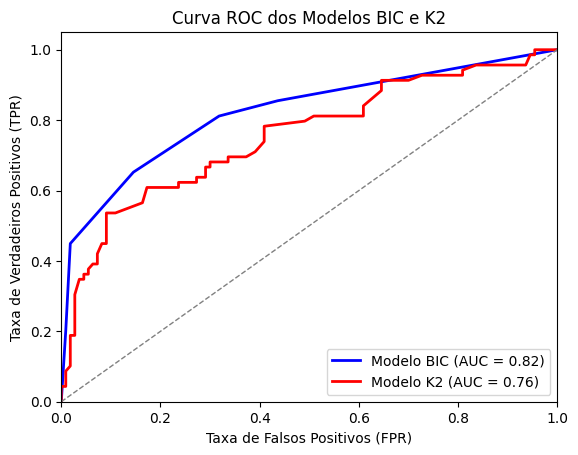

In [ ]:
# Plotar Curvas ROC

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular as curvas ROC para o modelo BIC
fpr_bic, tpr_bic, _ = roc_curve(test_data['Survived'], probabilities_bic)
roc_auc_bic = auc(fpr_bic, tpr_bic)

# Calcular as curvas ROC para o modelo K2
fpr_k2, tpr_k2, _ = roc_curve(test_data['Survived'], probabilities_k2)
roc_auc_k2 = auc(fpr_k2, tpr_k2)

# Plotar as curvas ROC
plt.figure()
plt.plot(fpr_bic, tpr_bic, color='blue', lw=2, label=f'Modelo BIC (AUC = {roc_auc_bic:.2f})')
plt.plot(fpr_k2, tpr_k2, color='red', lw=2, label=f'Modelo K2 (AUC = {roc_auc_k2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Linha de referência
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC dos Modelos BIC e K2')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Imprimir as arestas da Rede Bayesiana treinada com BIC Score
print("\nMelhor Estrutura Encontrada (Arestas - BIC Score):")
print(model_bic.edges())

# Imprimir as arestas da Rede Bayesiana treinada com K2 Score
print("\nEstrutura Alternativa (Arestas - K2 Score):")
print(model_k2.edges())



Melhor Estrutura Encontrada (Arestas - BIC Score):
[('Survived', 'Sex'), ('Pclass', 'Fare'), ('Pclass', 'Survived'), ('Pclass', 'Age'), ('Fare', 'SibSp'), ('Fare', 'Parch'), ('Embarked', 'Pclass')]

Estrutura Alternativa (Arestas - K2 Score):
[('Survived', 'Fare'), ('Survived', 'Age'), ('Survived', 'SibSp'), ('Fare', 'Age'), ('Fare', 'SibSp'), ('Age', 'SibSp'), ('Pclass', 'Fare'), ('Pclass', 'Age'), ('Pclass', 'Survived'), ('Pclass', 'SibSp'), ('Pclass', 'Sex'), ('Sex', 'Fare'), ('Sex', 'Survived'), ('Sex', 'Age'), ('Sex', 'SibSp'), ('Parch', 'Fare'), ('Parch', 'SibSp'), ('Parch', 'Age'), ('Parch', 'Sex'), ('Embarked', 'Fare'), ('Embarked', 'Pclass'), ('Embarked', 'Age'), ('Embarked', 'SibSp'), ('Embarked', 'Sex')]


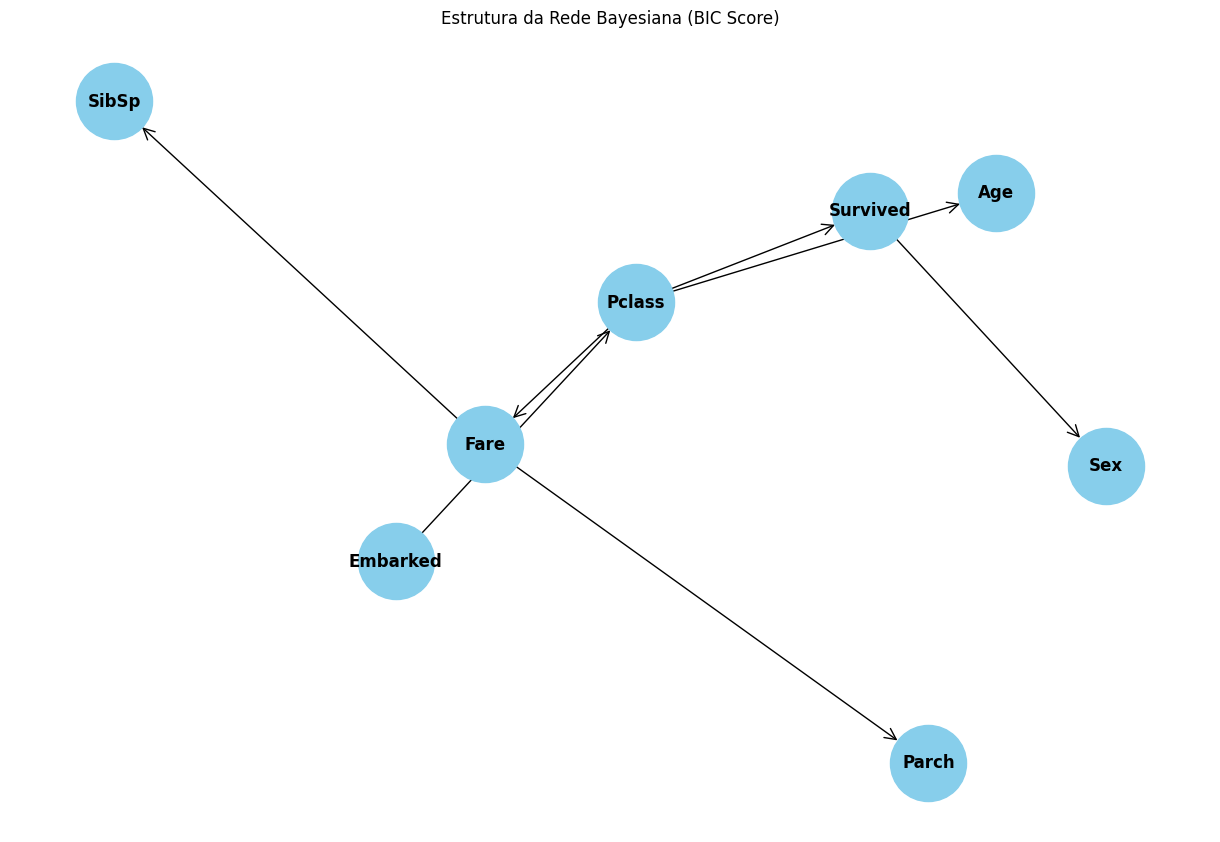

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Plotar a estrutura da Rede Bayesiana usando BIC Score
plt.figure(figsize=(12, 8))
G_bic = nx.DiGraph(model_bic.edges())
pos_bic = nx.spring_layout(G_bic, seed=42, k=1)  # Ajuste o parâmetro 'k' para melhor visualização
nx.draw(G_bic, pos_bic, with_labels=True, node_size=3000, node_color="skyblue",
        font_size=12, font_weight="bold", arrows=True, arrowstyle='->', arrowsize=20)
plt.title("Estrutura da Rede Bayesiana (BIC Score)")
plt.show()


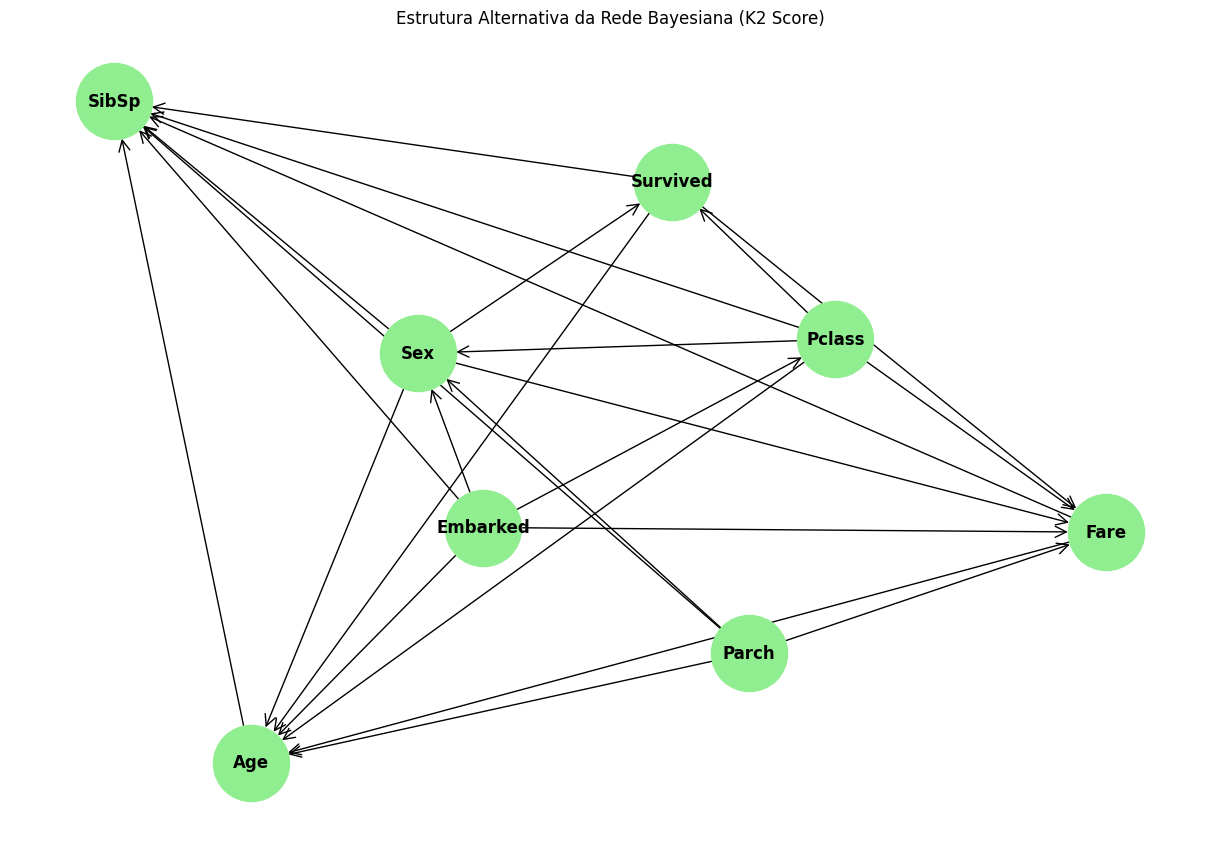

In [ ]:
# Plotar a estrutura da Rede Bayesiana usando K2 Score
plt.figure(figsize=(12, 8))
G_k2 = nx.DiGraph(model_k2.edges())
pos_k2 = nx.spring_layout(G_k2, seed=42, k=1)  # Ajuste o parâmetro 'k' para melhor visualização
nx.draw(G_k2, pos_k2, with_labels=True, node_size=3000, node_color="lightgreen",
        font_size=12, font_weight="bold", arrows=True, arrowstyle='->', arrowsize=20)
plt.title("Estrutura Alternativa da Rede Bayesiana (K2 Score)")
plt.show()


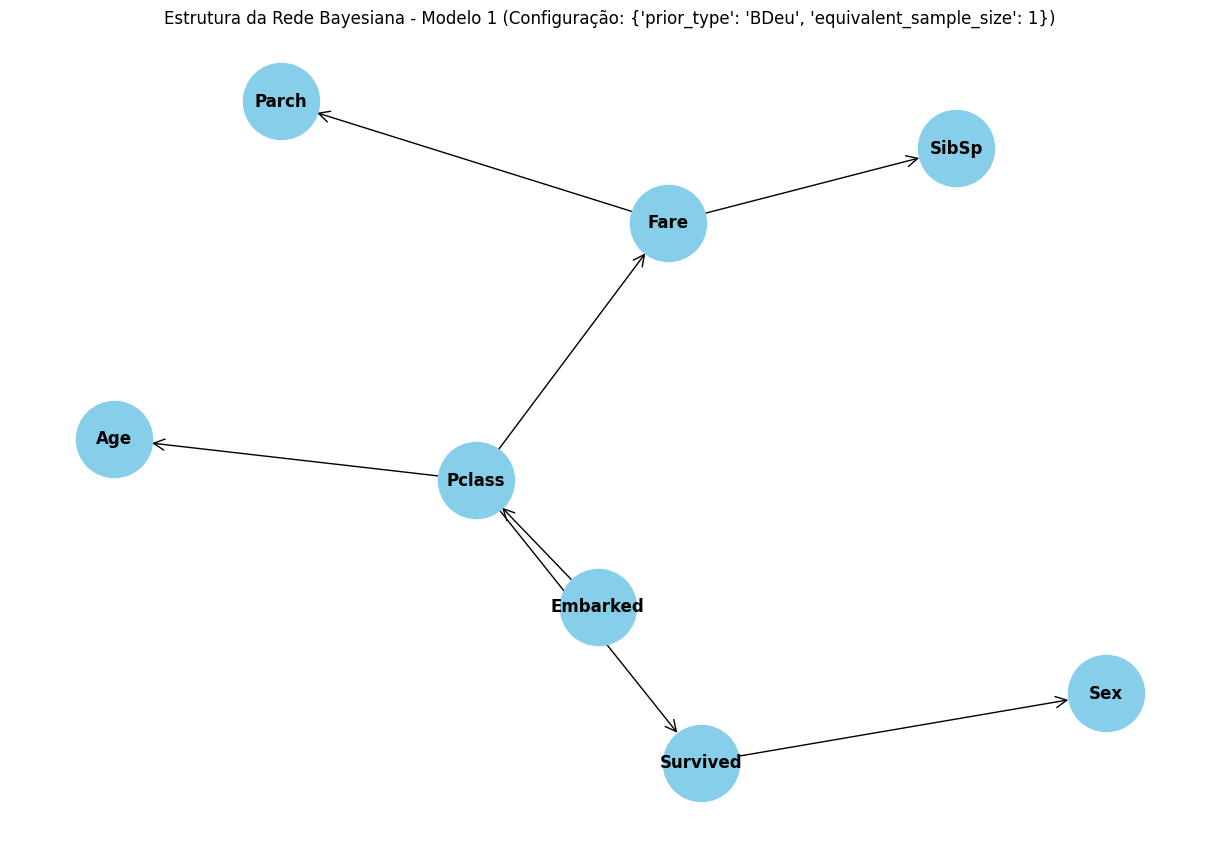

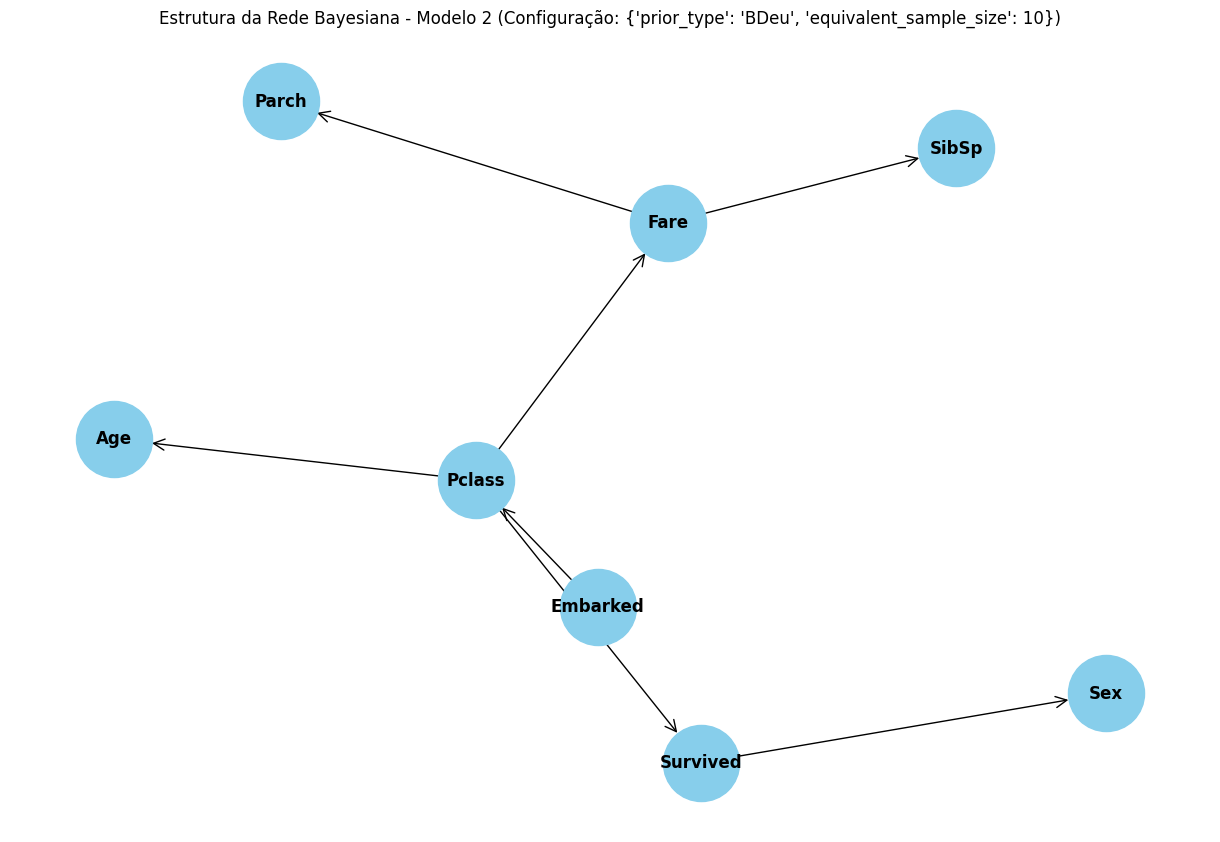

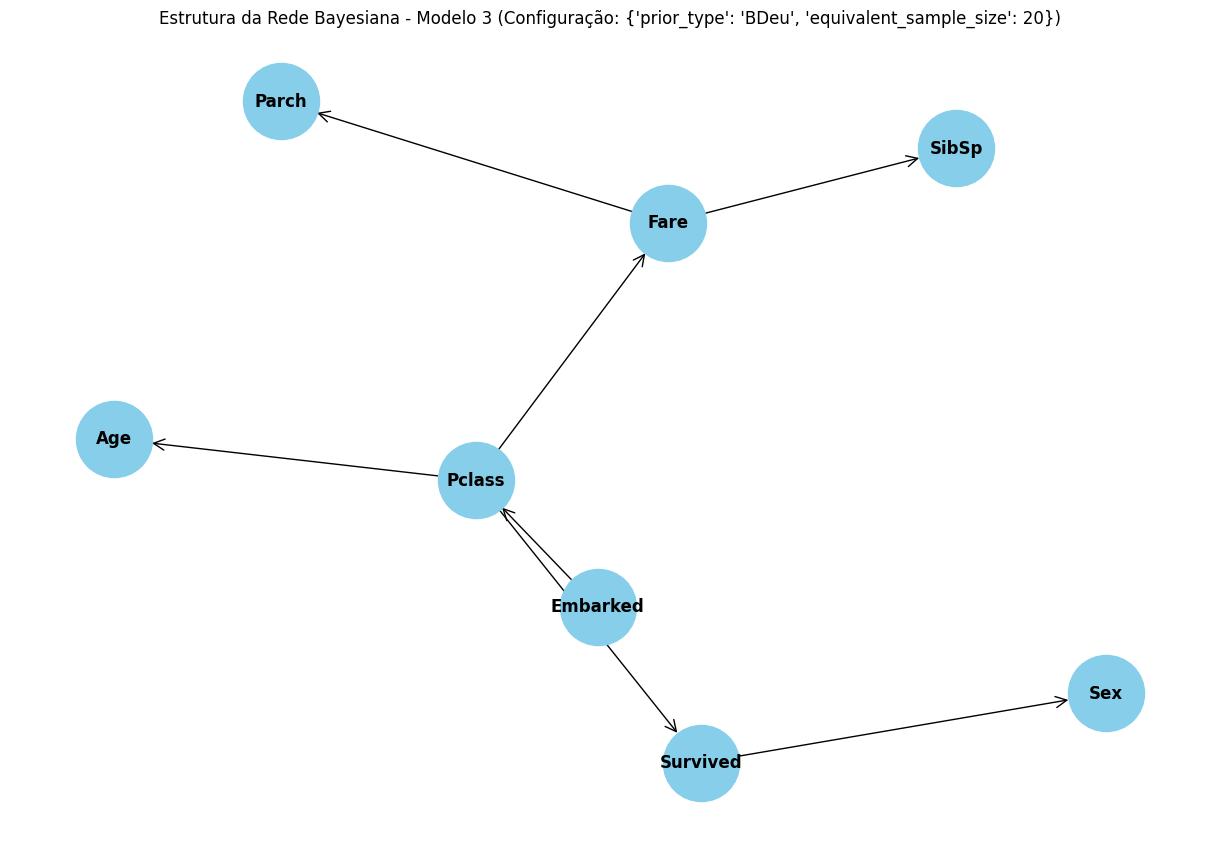

In [ ]:
# Iterar sobre todos os modelos treinados e plotar suas estruturas
for idx, model_info in enumerate(best_models):
    model = model_info['model']
    config = model_info['estimator_config']
    
    plt.figure(figsize=(12, 8))
    G = nx.DiGraph(model.edges())
    pos = nx.spring_layout(G, seed=42, k=1)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue",
            font_size=12, font_weight="bold", arrows=True, arrowstyle='->', arrowsize=20)
    plt.title(f"Estrutura da Rede Bayesiana - Modelo {idx+1} (Configuração: {config})")
    plt.show()


In [ ]:
# Imprimir as CPDs da Rede Bayesiana treinada com BIC Score
print("\nTabelas de Probabilidade Condicional (CPDs) - BIC Score:")
for cpd in model_bic.get_cpds():
    print(cpd)

# Imprimir as CPDs da Rede Bayesiana treinada com K2 Score
print("\nTabelas de Probabilidade Condicional (CPDs) - K2 Score:")
for cpd in model_k2.get_cpds():
    print(cpd)



Tabelas de Probabilidade Condicional (CPDs) - BIC Score:
+-------------+---------------------+-----+---------------------+
| Pclass      | Pclass(1)           | ... | Pclass(3)           |
+-------------+---------------------+-----+---------------------+
| Survived(0) | 0.35647279549718575 | ... | 0.7527242246437552  |
+-------------+---------------------+-----+---------------------+
| Survived(1) | 0.6435272045028143  | ... | 0.24727577535624476 |
+-------------+---------------------+-----+---------------------+
+----------+-------------------+---------------------+
| Survived | Survived(0)       | Survived(1)         |
+----------+-------------------+---------------------+
| Sex(0)   | 0.844097995545657 | 0.31802120141342755 |
+----------+-------------------+---------------------+
| Sex(1)   | 0.155902004454343 | 0.6819787985865724  |
+----------+-------------------+---------------------+
+-----------+---------------------+---------------------+---------------------+
| Embarked  | E


Melhor Estrutura Encontrada (Arestas - BIC Score):
[('Survived', 'Sex'), ('Pclass', 'Fare'), ('Pclass', 'Survived'), ('Pclass', 'Age'), ('Fare', 'SibSp'), ('Fare', 'Parch'), ('Embarked', 'Pclass')]

Estrutura Alternativa (Arestas - K2 Score):
[('Survived', 'Fare'), ('Survived', 'Age'), ('Survived', 'SibSp'), ('Fare', 'Age'), ('Fare', 'SibSp'), ('Age', 'SibSp'), ('Pclass', 'Fare'), ('Pclass', 'Age'), ('Pclass', 'Survived'), ('Pclass', 'SibSp'), ('Pclass', 'Sex'), ('Sex', 'Fare'), ('Sex', 'Survived'), ('Sex', 'Age'), ('Sex', 'SibSp'), ('Parch', 'Fare'), ('Parch', 'SibSp'), ('Parch', 'Age'), ('Parch', 'Sex'), ('Embarked', 'Fare'), ('Embarked', 'Pclass'), ('Embarked', 'Age'), ('Embarked', 'SibSp'), ('Embarked', 'Sex')]


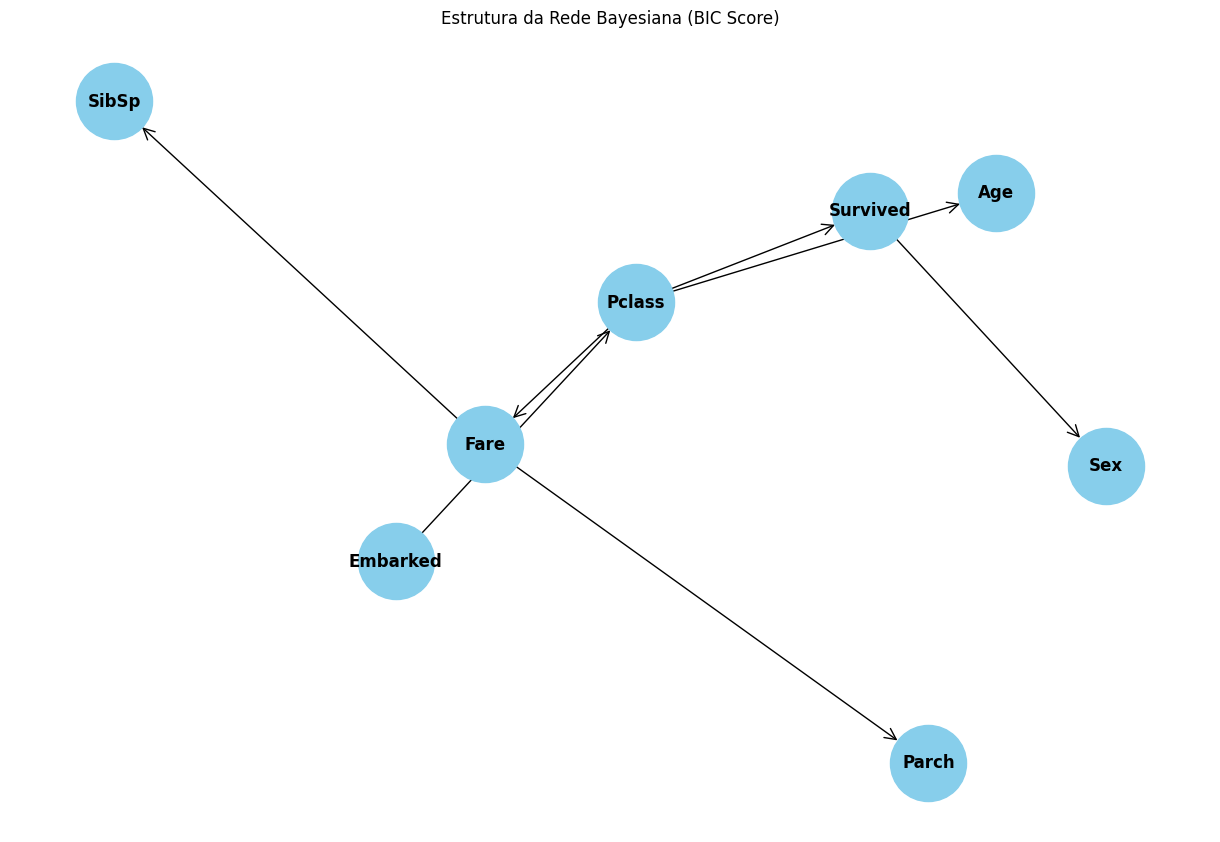

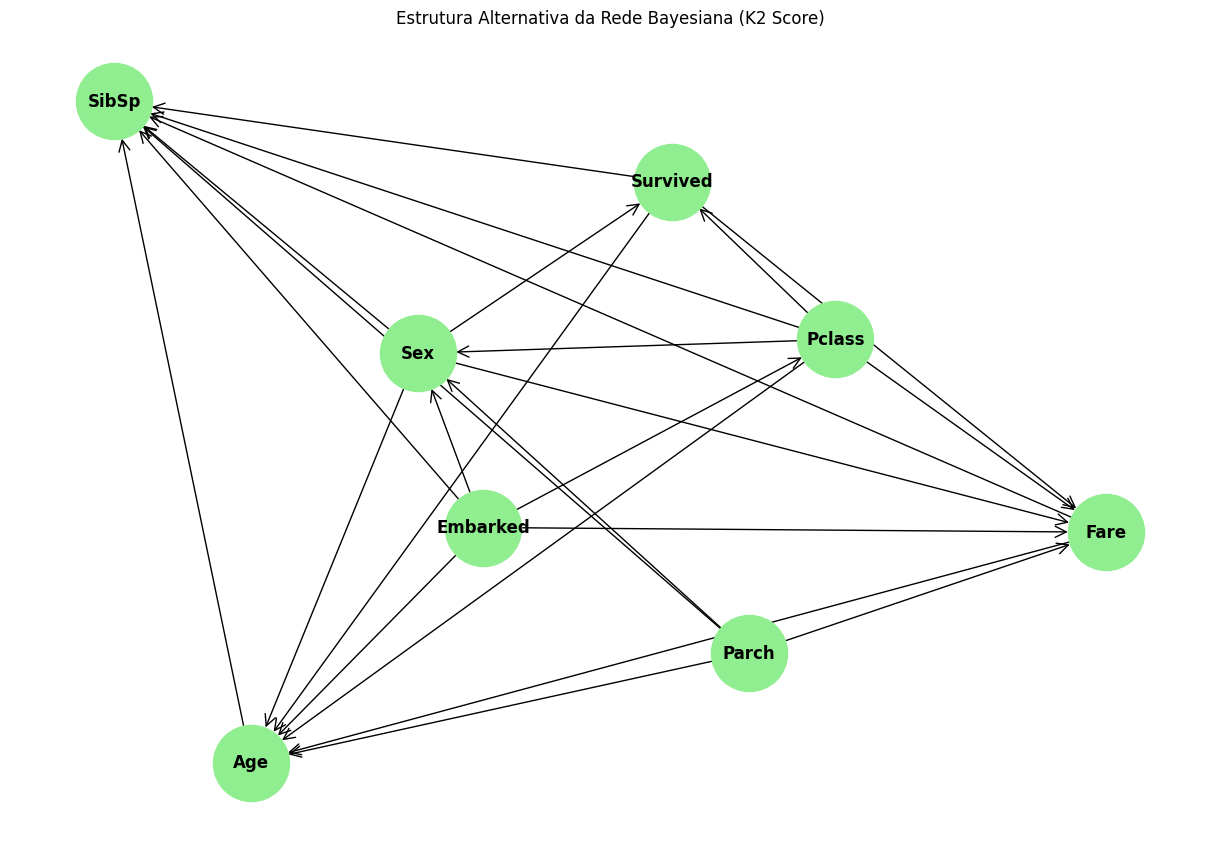


Tabelas de Probabilidade Condicional (CPDs) - BIC Score:
+-------------+---------------------+-----+---------------------+
| Pclass      | Pclass(1)           | ... | Pclass(3)           |
+-------------+---------------------+-----+---------------------+
| Survived(0) | 0.35647279549718575 | ... | 0.7527242246437552  |
+-------------+---------------------+-----+---------------------+
| Survived(1) | 0.6435272045028143  | ... | 0.24727577535624476 |
+-------------+---------------------+-----+---------------------+
+----------+-------------------+---------------------+
| Survived | Survived(0)       | Survived(1)         |
+----------+-------------------+---------------------+
| Sex(0)   | 0.844097995545657 | 0.31802120141342755 |
+----------+-------------------+---------------------+
| Sex(1)   | 0.155902004454343 | 0.6819787985865724  |
+----------+-------------------+---------------------+
+-----------+---------------------+---------------------+---------------------+
| Embarked  | E

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Imprimir as arestas
print("\nMelhor Estrutura Encontrada (Arestas - BIC Score):")
print(model_bic.edges())

print("\nEstrutura Alternativa (Arestas - K2 Score):")
print(model_k2.edges())

# Plotar a estrutura da Rede Bayesian com BIC Score
plt.figure(figsize=(12, 8))
G_bic = nx.DiGraph(model_bic.edges())
pos_bic = nx.spring_layout(G_bic, seed=42, k=1)
nx.draw(G_bic, pos_bic, with_labels=True, node_size=3000, node_color="skyblue",
        font_size=12, font_weight="bold", arrows=True, arrowstyle='->', arrowsize=20)
plt.title("Estrutura da Rede Bayesiana (BIC Score)")
plt.show()

# Plotar a estrutura da Rede Bayesian com K2 Score
plt.figure(figsize=(12, 8))
G_k2 = nx.DiGraph(model_k2.edges())
pos_k2 = nx.spring_layout(G_k2, seed=42, k=1)
nx.draw(G_k2, pos_k2, with_labels=True, node_size=3000, node_color="lightgreen",
        font_size=12, font_weight="bold", arrows=True, arrowstyle='->', arrowsize=20)
plt.title("Estrutura Alternativa da Rede Bayesiana (K2 Score)")
plt.show()

# Imprimir as CPDs
print("\nTabelas de Probabilidade Condicional (CPDs) - BIC Score:")
for cpd in model_bic.get_cpds():
    print(cpd)

print("\nTabelas de Probabilidade Condicional (CPDs) - K2 Score:")
for cpd in model_k2.get_cpds():
    print(cpd)
